In [1]:
from letters import LettersData
data = LettersData("data/", "list_expected_data.txt")
data.process()
#x,y = data.get_data()
#classes = data.get_classes()
#ysize = data.get_class_element_size()
#xsize = data.get_input_image_size()
#print(len(classes))
#print(len(classes['P']))
#print(xsize,ysize)
#print(len(x))
#print(len(y))
#print(y[5])
#print(data.get_vocab())
v=data.get_vocab_with_min_count(30)
print(v)
print(len(v))
batch = data.get_batches()
print(len(batch))
batch = data.get_batches()#min_count=40, mini_batch_size=577)
print("number of batches={}".format(len(batch)))
print("size of first batch={},{}".format(len(batch[0][0]),len(batch[0][1])))
print("size of last batch={},{}".format(len(batch[-1][0]),len(batch[-1][1])))
xsize = len(batch[0][0][0])
ysize = len(batch[0][1][0])
print(xsize, ysize)

{'l': {'count': 64, 'vector': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'index': 0}, 'u': {'count': 55, 'vector': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'index': 7}, 'o': {'count': 39, 'vector': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'index': 8}, 'e': {'count': 117, 'vector': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'index': 9}, 't': {'count': 64, 'vector': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'index': 1}, 'n': {'count': 75, 'vector': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'index': 10}, 's': {'count': 40, 'vector': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'index': 3}, 'a': {'count': 36, 'vector': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'index': 4}, 'd': {'count': 45, 'vector': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'index': 5}, 'c': {'count': 30, 'vector': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'index': 6}, 'i': {'count': 75, 'vector': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'index': 11}, 'r': {'count': 42, 'vector': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'index': 2}}
12
1
number of batches=1
size of fir

In [2]:
import numpy as np

def output_to_hard(output):
    m = output.shape[1]
    hard = np.zeros_like(output)
    hard[output.argmax(0), np.arange(m)] = 1
    return hard


def count_errors(output, expected_output):
    """Count the number of patterns different assuming dimension (n, m)
    having m patterns of size n
    """
    # check differences
    err = np.equal(output,expected_output)
    # invert such as true means not equal
    ierr = np.invert(err)
    # count number of bad values for each column
    nb = np.count_nonzero(ierr, axis=0)
    # count number of errors
    nb_err = np.count_nonzero(nb)
    return nb_err
        


a = np.array([[0, 1], [2, 3], [4, 5], [6, 7], [9, 8]]).T
print(a)
print(output_to_hard(a))
a = np.array([[11,2,13,4],[5,6,7,8]])
print(a)
b = np.array([[1, 0, 1, 0], [1, 1, 0, 1]])
h = output_to_hard(a)
print(h)

print(count_errors(h, b))


[[0 2 4 6 9]
 [1 3 5 7 8]]
[[0 0 0 0 1]
 [1 1 1 1 0]]
[[11  2 13  4]
 [ 5  6  7  8]]
[[1 0 1 0]
 [0 1 0 1]]
1


In [3]:
def all_axis_equal(n, axis=0):
    """
    :param axis: if 0 check that all columns are equal, if 1 chech rows
    """
    if axis == 0:
        res = np.std(n, axis=1)
    else:
        res = np.std(n)
    res = np.sum(res)
    return res == 0.


def axis_equal(n, axis=0):
    """
    :param axis: if 0 check that all columns are equal, if 1 chech rows
    """
    if axis == 0:
        res = np.std(n, axis=1)
    else:
        res = np.std(n)
    return res


a=np.array([[1,-2,3,4],[5,6,-7,8]])
all_axis_equal(a)
a=np.array([[1,-2,3,4],[1,6,-7,8]])
all_axis_equal(a) 

a = np.array([[-1., -1.], [-3., 3]])
print(np.std(a,axis=1))

b=np.array([[-2,-2,-2],[5,6,-7]])
print(all_axis_equal(b))
b=np.array([[-2,-2,-2],[5,5,5]])
print(all_axis_equal(b))

[0. 3.]
False
True


In [4]:
# FEATURES SAVE/LOAD FUNCTIONS

import struct

param_type = {
    "uint32": {"fmt": 'I', "size": 4},
    "float64": {"fmt": 'd', "size": 8},
}

def save_params(params, name):
    ret = False
    # nb layers
    nb = len(params)
    # nbs features per layer
    sizes = [p.size for p in params]
    # packing format string
    fmt = "<{fnb}{fsizes}{fparams}".format(
        fnb=param_type["uint32"]["fmt"],
        fsizes=param_type["uint32"]["fmt"]*nb,
        fparams="".join([param_type["float64"]["fmt"]*n for n in sizes])
    )
    # build the list of sizes and all parameters
    data = [nb] + sizes
    for p in params:
        data += p.flatten().tolist()
    print(sizes)
    # packing raw data
    raw = struct.pack(fmt, *data)
    print(len(raw))
    # save
    with open(name, "wb") as f:
        f.write(raw)
        ret = True
        print("ok")
    return ret

def load_params(name):
    """Load parameters from file.
    A main list contains lists of all parameters for each layer

    :return: dict with results
    """
    ret = {"result": False}
    with open(name, "rb") as f:
        # get nb layers
        raw = f.read(param_type["uint32"]["size"])
        fmt = "<{fnb}".format(fnb=param_type["uint32"]["fmt"])
        nb = struct.unpack(fmt, raw)[0]
        # get nbs features per layer
        raw = f.read(param_type["uint32"]["size"]*nb)
        fmt = "<{fsizes}".format(fsizes=param_type["uint32"]["fmt"]*nb)
        sizes = struct.unpack(fmt, raw)
        # get params
        total = sum(sizes)
        raw = f.read(param_type["float64"]["size"]*total)
        fmt = "<{fparams}".format(fparams=param_type["float64"]["fmt"]*total)
        params = struct.unpack(fmt, raw)
        # result
        ret["params"] = params
        ret["sizes"] = sizes
        ret["result"] = True
    return ret


In [5]:
# CREATE MLP

from mlp import MultiLayerPerceptron
import numpy as np

X, Y = np.array(batch[0][0]), np.array(batch[0][1])
xsize = len(batch[0][0][0])
ysize = len(batch[0][1][0])
print(batch[0][1][0])
m = len(batch[0][0])

# create MLP architecture
mlp = MultiLayerPerceptron(L=5, n=[xsize, 1800, 600, 300, 30, ysize], g=["tanh"]*4 + ["softmax"], alpha=0.001, set_random_w=False)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


tanh factor=0.05773502691896258
tanh factor=0.023570226039551584
tanh factor=0.040824829046386304
tanh factor=0.05773502691896258
softmax factor=0.01
(300, 815) 300 815
nb errors before training=774/815
Training...
(300, 815) 300 815


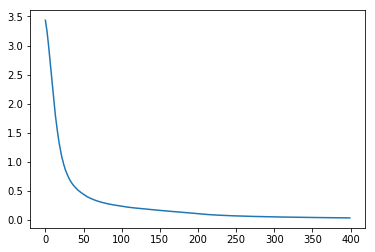

learning duration=423.7619242668152(s)
{'iterations': 400, 'cost_function': 0.03647720713386014}
nb errors=0/815


In [6]:
# TRAINING MLP

import time
mlp.init_random_weights(use_formula=True)
#mlp.use_regularization(0.1)
mlp.use_adam()

# Compute output
output = mlp.compute_outputs(X.T)
hard_output = output_to_hard(output)
mlp.set_all_expected_output_examples(Y.T)
expected_output = mlp.get_expected_output()
print("nb errors before training={}/{}".format(count_errors(hard_output, expected_output), output.shape[1]))

# Proceed learning with gradient descent
print("Training...")
t0 = time.time()
res = mlp.learning(X.T, Y.T, m, min_cost=0.005, max_iter=400, plot=True)
t1 = time.time()
print("learning duration={}(s)".format(t1-t0))
print(res)

output = mlp.get_output()
hard_output = output_to_hard(output)
expected_output = mlp.get_expected_output()
print("nb errors={}/{}".format(count_errors(hard_output, expected_output), output.shape[1]))


In [7]:
# SHOW STATS

print(mlp.get_expected_output())
o = mlp.get_output()#[:,:5]
print("out={}".format(o))
print("alleq? =",all_axis_equal(o))
print("eq? =",axis_equal(o))
h = output_to_hard(o)
print("hout={}".format(h))
print("alleq? =",all_axis_equal(h))
e = mlp.get_expected_output()#[:,:5]
print("expout={}".format(e))
print("nb errors={}".format(count_errors(h, e)))
#print(mlp.get_weights())
i = mlp.get_input()
print("ieq? =",axis_equal(i))
print("i? =",i)
print("diff exp=", np.sum(e,axis=1))
W=mlp.get_weights()
ln=[]
for w in W:
    print(w)
    ln.append(len(w))
    print(w.dtype)
print(ln)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
out=[[4.02037550e-05 5.08508797e-04 1.06952737e-04 ... 6.90627241e-04
  4.48964139e-05 2.14162585e-04]
 [1.84800747e-03 9.71943093e-06 8.52629012e-05 ... 1.29846509e-05
  4.41800847e-03 3.40338342e-04]
 [1.08228023e-02 2.15103553e-04 1.59061695e-05 ... 1.48215408e-06
  9.09058825e-01 2.00836526e-03]
 ...
 [3.18261532e-03 5.26193930e-05 5.05545438e-08 ... 4.32711136e-05
  7.19238954e-03 8.67241619e-01]
 [6.34245842e-04 4.93213135e-05 4.57927769e-07 ... 3.76821169e-04
  6.03246442e-04 2.92431724e-02]
 [1.31052791e-02 8.18982449e-06 5.47497733e-07 ... 8.46367980e-05
  2.17122828e-03 2.62691643e-02]]
alleq? = False
eq? = [0.25924556 0.08267856 0.04282241 0.25607265 0.20887564 0.1516461
 0.21388612 0.19943628 0.22536132 0.18298195 0.13134766 0.05186903
 0.11161251 0.06383863 0.02833336 0.14028731 0.23607068 0.19713953
 0.34331537 0.15790335 0.28469948 0.02592643 0.06598417

In [8]:
# SAVE FEATURES
import datetime

tm = str(datetime.datetime.now()).replace(" ", "_").split(".")[0]

W=mlp.get_weights()
err = count_errors(h, e)
name = "weights_"+str(err)+"-815_" + tm + ".params"
save_params(W, name)
print(name)
b=mlp.get_bias()
b = mlp._b[1:]
name = "bias_"+str(err)+"-815_" + tm + ".params"
save_params(b, name)
print(name)

[540000, 1080000, 180000, 9000, 930]
14479464
ok
weights_0-815_2018-01-16_22:36:45.params
[1800, 600, 300, 30, 31]
22112
ok
bias_0-815_2018-01-16_22:36:45.params


In [9]:
# GENERALIZATION

# load params from file
res = load_params("weights_0-815_2018-01-16_22:36:45.params")
W = res["params"]
res = load_params("bias_0-815_2018-01-16_22:36:45.params")
b = res["params"]

# set MLP
mlp.set_flatten_weights(W)
mlp.set_flatten_bias(b)

# Compute outputs
e = batch[0][1][0]
#X = np.array(batch[0][0][0]).reshape(1, len(batch[0][0][0]))

print("expected: '{}'".format(data.get_letter_of_vector(e)))
#mlp.set_all_input_examples(X.T)
#mlp.set_all_input_examples(X.T, m=X.shape[0])
mlp.set_all_training_examples(X.T,Y.T,m=X.shape[0])
print(mlp.compute_outputs())
res = output_to_hard(mlp.compute_outputs())
print(res)
print(res[:,0].flatten().tolist())
# check the first input image
print("recognized: '{}'".format(data.get_letter_of_vector(res[:,0].flatten().tolist())))
print("expected: '{}'".format(data.get_letter_of_vector(Y.T[:,0].flatten().tolist())))
print(res[:,0])
print(Y.T[:,0])

expected: 'P'
(300, 815) 300 815
[[4.02037550e-05 5.08508797e-04 1.06952737e-04 ... 6.90627241e-04
  4.48964139e-05 2.14162585e-04]
 [1.84800747e-03 9.71943093e-06 8.52629012e-05 ... 1.29846509e-05
  4.41800847e-03 3.40338342e-04]
 [1.08228023e-02 2.15103553e-04 1.59061695e-05 ... 1.48215408e-06
  9.09058825e-01 2.00836526e-03]
 ...
 [3.18261532e-03 5.26193930e-05 5.05545438e-08 ... 4.32711136e-05
  7.19238954e-03 8.67241619e-01]
 [6.34245842e-04 4.93213135e-05 4.57927769e-07 ... 3.76821169e-04
  6.03246442e-04 2.92431724e-02]
 [1.31052791e-02 8.18982449e-06 5.47497733e-07 ... 8.46367980e-05
  2.17122828e-03 2.62691643e-02]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
recognized: 'P'
expected: 'P'
[0. 0. 0. 0. 0. 0. 0. 0. 

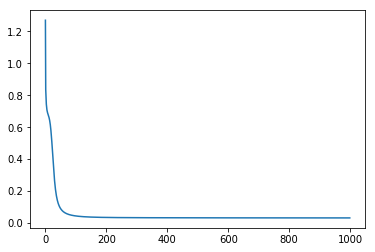

{'iterations': 1000, 'cost_function': 0.031307411466539793}
[[ 0.01201341  0.98092967  0.98092663  0.02404195]
 [ 0.98798659  0.01907033  0.01907337  0.97595805]]
[array([[-2.40378742,  2.05154928],
       [ 1.09713928,  1.09693386],
       [ 2.05046244, -2.40358981]]), array([[ 2.57638752,  0.99113136,  2.57718917],
       [-2.60126558, -0.77456271, -2.6004823 ]])]


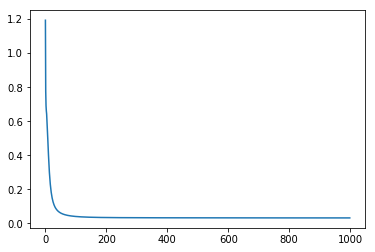

{'iterations': 1000, 'cost_function': 0.031190216120355926}
[[ 0.01277621  0.9811383   0.98114161  0.02333379]
 [ 0.98722379  0.0188617   0.01885839  0.97666621]]
[array([[-1.01205709, -1.01200878],
       [ 2.08751553, -2.38975991],
       [-2.38947784,  2.08601873]]), array([[-0.78583897,  2.64231438,  2.5581069 ],
       [ 0.77756604, -2.57364066, -2.65805014]])]


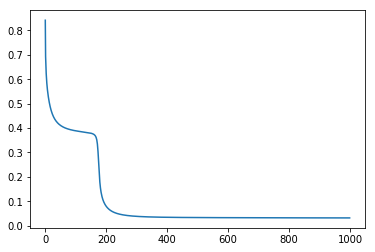

{'iterations': 1000, 'cost_function': 0.03171314920552748}
[[ 0.01947007  0.97421129  0.98964546  0.01990589]
 [ 0.98052993  0.02578871  0.01035454  0.98009411]]
[array([[ 1.31420216, -1.30600905],
       [-1.99140538, -2.44175863],
       [-2.37396126, -1.90332763]]), array([[ 1.09790652, -2.56363219,  2.62272519],
       [-1.17325226,  2.53073242, -2.49247235]])]


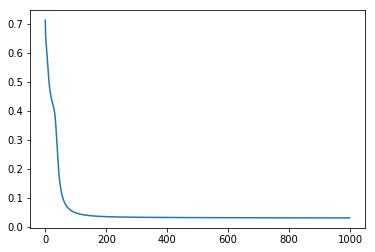

{'iterations': 1000, 'cost_function': 0.031608250656706208}
[[ 0.01040672  0.98043232  0.98045294  0.02558199]
 [ 0.98959328  0.01956768  0.01954706  0.97441801]]
[array([[ 1.95863856, -2.4323066 ],
       [ 1.29725725,  1.29857176],
       [ 2.43125627, -1.95172388]]), array([[ 2.60363554,  1.11416206, -2.65643781],
       [-2.49021505, -1.09446745,  2.43728256]])]


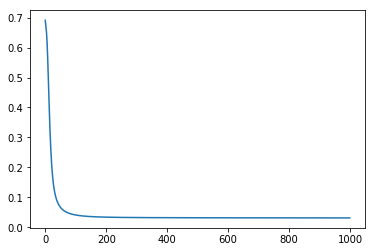

{'iterations': 1000, 'cost_function': 0.031173368398727086}
[[ 0.01325791  0.98116572  0.98116461  0.02288485]
 [ 0.98674209  0.01883428  0.01883539  0.97711515]]
[array([[ 0.94818634,  0.94787128],
       [-2.11042432,  2.38249017],
       [ 2.38249803, -2.1105769 ]]), array([[ 0.68033473, -2.55026254, -2.63855001],
       [-0.79177884,  2.68207786,  2.59393157]])]


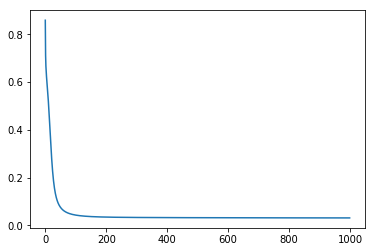

{'iterations': 1000, 'cost_function': 0.03154258548825048}
[[ 0.01070599  0.98053425  0.98054138  0.02528557]
 [ 0.98929401  0.01946575  0.01945862  0.97471443]]
[array([[ 2.42644979, -1.97438771],
       [-1.97687282,  2.42683032],
       [ 1.25642219,  1.25681975]]), array([[-2.50547448, -2.4802892 ,  1.03686812],
       [ 2.60455426,  2.62973858, -1.08774409]])]


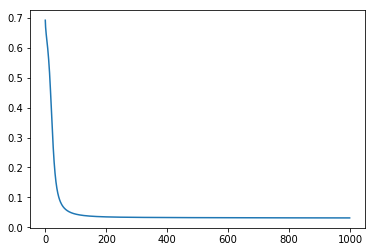

{'iterations': 1000, 'cost_function': 0.031525533033675182}
[[ 0.01074898  0.98057629  0.98056179  0.02524762]
 [ 0.98925102  0.01942371  0.01943821  0.97475238]]
[array([[ 1.97510636, -2.42520404],
       [-1.25432208, -1.25347711],
       [-2.42596987,  1.98011715]]), array([[ 2.6373461 , -1.08073471,  2.5626286 ],
       [-2.47595591,  1.02462783, -2.55069231]])]


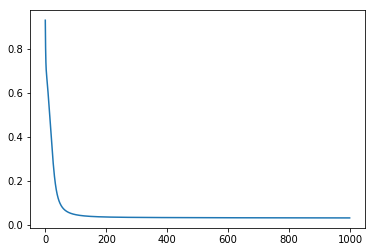

{'iterations': 1000, 'cost_function': 0.031683047301714236}
[[ 0.01018743  0.98029666  0.98032557  0.02578303]
 [ 0.98981257  0.01970334  0.01967443  0.97421697]]
[array([[-2.43573983,  1.93739017],
       [ 1.94743329, -2.43717401],
       [ 1.31728188,  1.31872773]]), array([[ 2.62528113,  2.58070129,  1.19489233],
       [-2.45354582, -2.49815408, -1.102795  ]])]


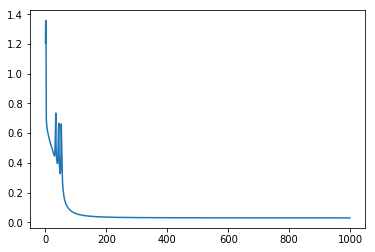

{'iterations': 1000, 'cost_function': 0.029568589776941649}
[[ 0.01511589  0.98320551  0.98320552  0.01904326]
 [ 0.98488411  0.01679449  0.01679448  0.98095674]]
[array([[-1.68718666, -1.68717444],
       [ 1.83309543,  1.83310216],
       [ 2.30099652,  2.30099339]]), array([[-1.62268664,  1.73477196, -2.79082854],
       [ 1.45111486, -1.79528538,  2.86262592]])]


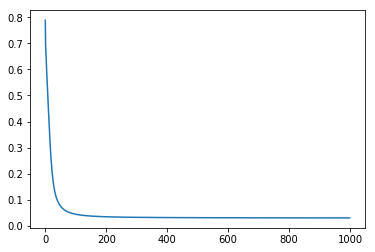

{'iterations': 1000, 'cost_function': 0.029539589789047232}
[[ 0.01679547  0.98104616  0.98492497  0.01677683]
 [ 0.98320453  0.01895384  0.01507503  0.98322317]]
[array([[-1.79884923,  1.79823306],
       [ 1.70777996, -1.71099719],
       [-2.30993664,  2.31112542]]), array([[-1.80202919,  1.54409123,  3.00612475],
       [ 1.65069614, -1.6289642 , -2.64412463]])]


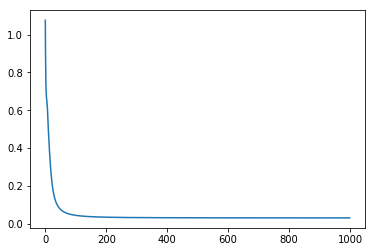

{'iterations': 1000, 'cost_function': 0.030909668962820103}
[[ 0.0182439   0.98169159  0.98170459  0.01828506]
 [ 0.9817561   0.01830841  0.01829541  0.98171494]]
[array([[-2.29039539,  2.29288139],
       [-2.27465684,  2.27075963],
       [-0.32154128,  0.36092221]]), array([[-2.72086854,  2.66959205,  0.15999313],
       [ 2.69089272, -2.65182681, -0.25901182]])]


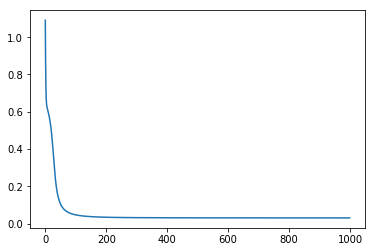

{'iterations': 1000, 'cost_function': 0.030990839306405914}
[[ 0.01813026  0.98143277  0.98141819  0.01828576]
 [ 0.98186974  0.01856723  0.01858181  0.98171424]]
[array([[-2.29004145,  2.28505435],
       [-2.28251732,  2.28899117],
       [-0.12602234, -0.07785231]]), array([[ 2.6566979 , -2.65259994, -0.16570456],
       [-2.7076025 ,  2.70871881,  0.10802586]])]


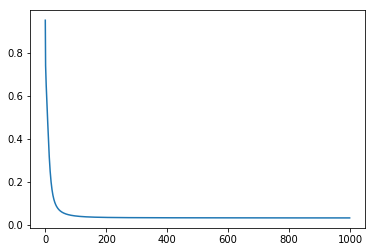

{'iterations': 1000, 'cost_function': 0.031172163993440746}
[[ 0.01323903  0.98116568  0.98116371  0.0228989 ]
 [ 0.98676097  0.01883432  0.01883629  0.9771011 ]]
[array([[-2.10901333,  2.38250007],
       [-0.95006233, -0.94990313],
       [-2.38264612,  2.10972493]]), array([[-2.61208829, -0.73383215,  2.5480982 ],
       [ 2.62017598,  0.74351283, -2.6841455 ]])]


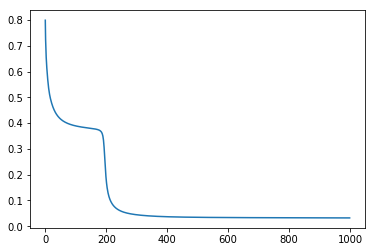

{'iterations': 1000, 'cost_function': 0.032040197611202727}
[[ 0.01980879  0.99050958  0.97326637  0.0205133 ]
 [ 0.98019121  0.00949042  0.02673363  0.9794867 ]]
[array([[-2.46362625, -1.95001825],
       [ 1.42435576, -1.41739194],
       [ 1.80506112,  2.35899248]]), array([[-2.55030002, -1.29993761, -2.61261471],
       [ 2.50032809,  1.30450224,  2.46367636]])]


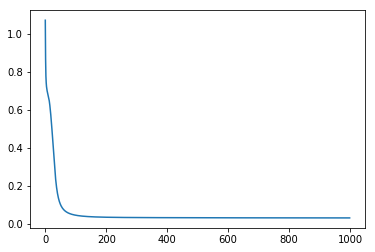

{'iterations': 1000, 'cost_function': 0.031513758450649069}
[[ 0.01084562  0.98057713  0.98059074  0.02515126]
 [ 0.98915438  0.01942287  0.01940926  0.97484874]]
[array([[ 1.23841713,  1.2391942 ],
       [-1.98703322,  2.42462157],
       [ 2.42389936, -1.98229619]]), array([[ 0.94829548, -2.58994826, -2.57924959],
       [-1.13555925,  2.52750395,  2.53819839]])]


In [29]:
from mlp import MultiLayerPerceptron
import numpy as np
#mlp = MultiLayerPerceptron(L=1, n=[2, 1], g=["sigmoid"], alpha=0.1)

X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

Y = np.array([[0, 1],
              [1, 0],
              [1, 0],
              [0, 1]])
#Y = np.array([[0],
#              [1],
#              [1],
#              [0]])

for i in range(15):
    mlp = MultiLayerPerceptron(L=2, n=[2, 3, 2], g=["tanh", "tanh"], alpha=1, w_rand_factor=1)
    mlp.use_regularization(lambd=0.01)
    #mlp.use_rmsprop()
    res = mlp.learning(X.T, Y.T, 4, max_iter=1000, plot=True)
    print(res)
    print(mlp.get_output())
    print(mlp.get_weights())
#mlp.set_all_training_examples(X.T, Y.T, 4)
#mlp.prepare()
#print(mlp.propagate())
#for i in range(100):
#    print(mlp.back_propagation())
#    mlp.propagate()
#print(mlp.propagate())


In [10]:
import numpy as np

a = np.ones((4,1))
a[0] = 3
a[2] = 41
res = np.zeros((4,1))
res = a / np.sum(a)
print(res)
print(np.sum(res))

[[ 0.06521739]
 [ 0.02173913]
 [ 0.89130435]
 [ 0.02173913]]
1.0


In [20]:
np.sum(np.array([ 0.00015156,  0.00015268,  0.00015293,  0.00015146,  0.0001536,   0.0001529,
   0.0001529,   0.0001523,   0.00014965,  0.0001527,   0.00015024,  0.00015229,
   0.00015458  ,0.00015043  ,0.00015286,  0.00015533,  0.00015488,  0.00015392,
   0.00015377 , 0.0001549 ,  0.0001537 ,  0.00015145 , 0.00014796 , 0.00014766,
   0.00014974 , 0.00015326  ,0.00014838,  0.00015275 , 0.00015331,  0.00015493,
   0.0001541  , 0.00015162]))

0.0048747400000000007

In [16]:
a=np.array([[1,-2,3,4],[5,6,-7,8]])
b = np.array(a)
a[:,1:].T
b
print(a)
print(np.maximum(a,0))
print(np.sum(a,axis=0))
s=np.sum(a,axis=0)
print("n=",all_axis_equal(a))
a[a>0]=1
print(np.all(a,axis=0))

[[ 1 -2  3  4]
 [ 5  6 -7  8]]
[[1 0 3 4]
 [5 6 0 8]]
[ 6  4 -4 12]
[ 6  4 -4 12]
n= False
[ True  True  True  True]


In [6]:
a=[0,1,2]
a[0:1]
a[1:1+2]

[1, 2]

In [8]:
import numpy as np
np.reshape([1,2,3,4], (2,2))

array([[1, 2],
       [3, 4]])